# A Network Tour of Data Science
### &nbsp; &nbsp; &nbsp; Xavier Bresson, Winter 2016/17
## Assignment 2 : Convolutional Neural Networks

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import time
import collections
import os

import matplotlib.pyplot as plt
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load small part of CIFAR dataset
[X_train, y_train, X_test, y_test] = np.load(os.path.join('datasets', 'cifar.npy'))

# Convert to float
train_data_orig = X_train.astype('float32')
y_train = y_train.astype('float32')
test_data_orig = X_test.astype('float32')
y_test = y_test.astype('float32')

# See shapes of matrices
print('Training data shape: ', train_data_orig.shape)
print('Training label shape: ', y_train.shape)
print('Test data shape: ', test_data_orig.shape)
print('Test label shape: ', y_test.shape)

Training data shape:  (2500, 32, 32, 3)
Training label shape:  (2500,)
Test data shape:  (100, 32, 32, 3)
Test label shape:  (100,)


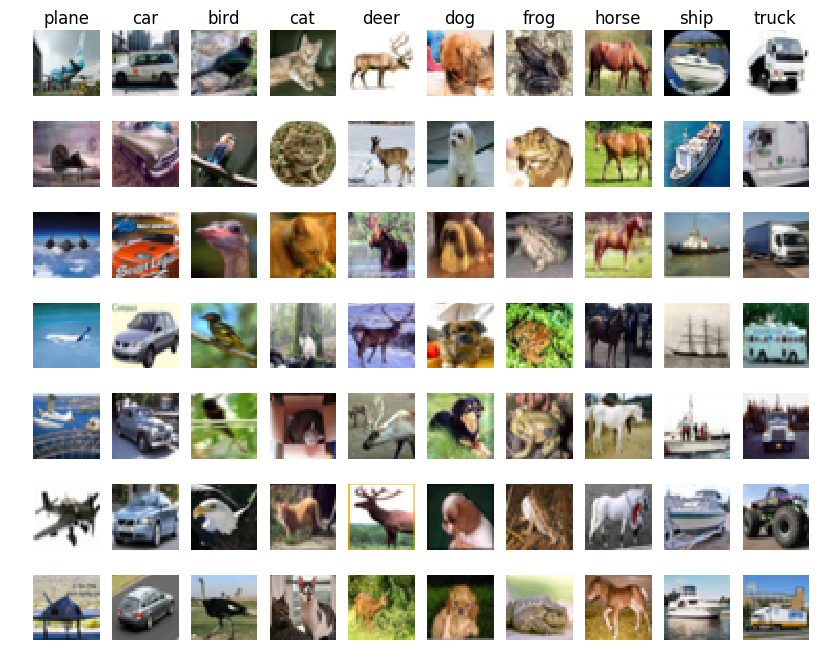

In [3]:
# Visualize a few examples of training images from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        xx = train_data_orig[idx,:,:,:]
        xx -= np.min(xx)
        xx /= np.max(xx)
        plt.imshow(xx)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Data pre-processing
n = train_data_orig.shape[0]
train_data = np.zeros([n,32**2])
for i in range(n):
    xx = train_data_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i] = np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,32**2])
for i in range(n):
    xx = test_data_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

print(train_data.shape)
print(test_data.shape)

(2500, 1024)
(100, 1024)


In [5]:
# Convert label values to one_hot vector
from scipy.sparse import coo_matrix
def convert_to_one_hot(a,max_val=None):
    N = a.size
    data = np.ones(N,dtype=int)
    sparse_out = coo_matrix((data,(np.arange(N),a.ravel())), shape=(N,max_val))
    return np.array(sparse_out.todense())

train_labels = convert_to_one_hot(y_train,10)
test_labels = convert_to_one_hot(y_test,10)

print(train_labels.shape)
print(test_labels.shape)

(2500, 10)
(100, 10)


# Model 1
**Question 1** Define with TensorFlow a linear classifier model:

$$
y=\textrm{softmax}(xW+b)
$$

Compute the train accuracy and the test accuracy (you should get a test accuracy around 25% at iteration 10,000)<br><br>
Hints: <br>
(1) You may use functions *tf.matmul(), tf.nn.softmax()*<br>
(2) You may use Xavier's initialization discussed during lectures for W, and b=0<br>
(3) You may use optimization schemes *tf.train.GradientDescentOptimizer(), tf.train.AdamOptimizer()*<br>

In [6]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())

# Fully Connected layer
W = tf.Variable(tf.truncated_normal([d,nc], stddev=tf.sqrt(6./tf.to_float(d+nc)) )); #print('W=',W.get_shape())
b = tf.Variable(tf.zeros([nc])); #print('b=',b.get_shape())
y = tf.matmul(xin, W); #print('y1=',y,y.get_shape())
y += b; #print('y2=',y,y.get_shape())

# Softmax
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.09 , loss= 2.30283
test accuracy= 0.09

Iteration i= 1000 , train accuracy= 0.36 , loss= 1.87004
test accuracy= 0.35

Iteration i= 2000 , train accuracy= 0.45 , loss= 1.77595
test accuracy= 0.34

Iteration i= 3000 , train accuracy= 0.43 , loss= 1.7689
test accuracy= 0.33

Iteration i= 4000 , train accuracy= 0.31 , loss= 1.83218
test accuracy= 0.29

Iteration i= 5000 , train accuracy= 0.47 , loss= 1.71852
test accuracy= 0.27

Iteration i= 6000 , train accuracy= 0.51 , loss= 1.67397
test accuracy= 0.25

Iteration i= 7000 , train accuracy= 0.47 , loss= 1.64769
test accuracy= 0.24

Iteration i= 8000 , train accuracy= 0.54 , loss= 1.60107
test accuracy= 0.25

Iteration i= 9000 , train accuracy= 0.5 , loss= 1.5663
test accuracy= 0.23

Iteration i= 10000 , train accuracy= 0.55 , loss= 1.46647
test accuracy= 0.23


# Model 2
**Question 2a.** Define with TensorFlow a 2-layer neural network classifier:

$$
y=\textrm{softmax}(ReLU(xW_1+b_1)W_2+b_2)
$$

Compute the train accuracy and the test accuracy (you should be able to overfit the train set)<br>
Hint: You may use functions *tf.nn.relu()*<br><br>

**Question 2b.** Add a L2 regularization term to prevent overfitting. Compute the train accuracy and the test accuracy (you should get a test accuracy around 35%)<br>
Hints: <br>
(1) You may use functions *tf.nn.l2_loss()*<br>
(2) Do not forget the constant parameter *reg_par*: total_loss = cross_entropy + reg_par* reg_loss<br>

In [8]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())

# 1st Fully Connected layer
nfc1 = 100
Wfc1 = tf.Variable(tf.truncated_normal([d,nfc1], stddev=tf.sqrt(6./tf.to_float(d+nfc1)) )); #print('Wfc1=',Wfc1.get_shape())
bfc1 = tf.Variable(tf.zeros([nfc1])); #print('bfc1=',bfc1.get_shape())
y = tf.matmul(xin, Wfc1); #print('y1=',y,y.get_shape())
y += bfc1; #print('y2=',y,y.get_shape())

# ReLU activation
y = tf.nn.relu(y)

# 2nd Fully Connected layer
Wfc2 = tf.Variable(tf.truncated_normal([nfc1,nc], stddev=tf.sqrt(6./tf.to_float(nfc1+nc)) )); #print('Wfc2=',Wfc2.get_shape())
bfc2 = tf.Variable(tf.zeros([nc])); #print('bfc2=',bfc2.get_shape())
y = tf.matmul(y, Wfc2); #print('y1b=',y,y.get_shape())
y += bfc2; #print('y2b=',y,y.get_shape())

# Softmax
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))

# L2 Regularization
reg_loss = 0.0
reg_loss += tf.nn.l2_loss(Wfc1)
reg_loss += tf.nn.l2_loss(bfc1)
reg_loss += tf.nn.l2_loss(Wfc2)
reg_loss += tf.nn.l2_loss(bfc2)
reg_par = 1*1e-3
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.13 , loss= 2.55773
test accuracy= 0.21

Iteration i= 1000 , train accuracy= 0.57 , loss= 1.69043
test accuracy= 0.43

Iteration i= 2000 , train accuracy= 0.79 , loss= 1.4181
test accuracy= 0.38

Iteration i= 3000 , train accuracy= 0.77 , loss= 1.48924
test accuracy= 0.37

Iteration i= 4000 , train accuracy= 0.87 , loss= 1.40621
test accuracy= 0.37

Iteration i= 5000 , train accuracy= 0.89 , loss= 1.34421
test accuracy= 0.34

Iteration i= 6000 , train accuracy= 0.91 , loss= 1.31852
test accuracy= 0.38

Iteration i= 7000 , train accuracy= 0.96 , loss= 1.27738
test accuracy= 0.39

Iteration i= 8000 , train accuracy= 0.92 , loss= 1.3528
test accuracy= 0.35

Iteration i= 9000 , train accuracy= 0.91 , loss= 1.28683
test accuracy= 0.4

Iteration i= 10000 , train accuracy= 0.95 , loss= 1.29855
test accuracy= 0.38


# Model 3
**Question 3.** Define a convolutional neural network classifier:

$$
y=\textrm{softmax}(ReLU(x\ast W_1+b_1)W_2+b_2)
$$

Hint: You may use function *tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME')* <br>
with *Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=YOUR CODE HERE ))*
for the convolution operator $\ast$<br>
and *x_2d = tf.reshape(xin, [-1,32,32,1])*<br>

Compute the train accuracy and the test accuracy (you should be able to overfit the train set)<br><br>

In [10]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())


# Convolutional layer
K = 5   # size of the patch
F = 10  # number of filters
ncl = K*K*F
Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=tf.sqrt(2./tf.to_float(ncl)) )); #print('Wcl=',Wcl.get_shape())
bcl = tf.Variable(tf.zeros([F])); #print('bcl=',bcl.get_shape())
x_2d = tf.reshape(xin, [-1,32,32,1]); #print('x_2d=',x_2d.get_shape())
x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME')
x += bcl; #print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Fully Connected layer
nfc = 32*32*F
x = tf.reshape(x, [batch_size,-1]); #print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(6./tf.to_float(nfc+nc)) )); #print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); #print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); #print('y1=',y,y.get_shape())
y += bfc; #print('y2=',y,y.get_shape())

# Softmax
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.09 , loss= 2.30147
test accuracy= 0.27

Iteration i= 1000 , train accuracy= 0.78 , loss= 0.83385
test accuracy= 0.47

Iteration i= 2000 , train accuracy= 0.96 , loss= 0.365053
test accuracy= 0.43

Iteration i= 3000 , train accuracy= 1.0 , loss= 0.11215
test accuracy= 0.43

Iteration i= 4000 , train accuracy= 1.0 , loss= 0.0405993
test accuracy= 0.41

Iteration i= 5000 , train accuracy= 1.0 , loss= 0.0227767
test accuracy= 0.38

Iteration i= 6000 , train accuracy= 1.0 , loss= 0.00813836
test accuracy= 0.4

Iteration i= 7000 , train accuracy= 1.0 , loss= 0.00548526
test accuracy= 0.36

Iteration i= 8000 , train accuracy= 1.0 , loss= 0.00261935
test accuracy= 0.35

Iteration i= 9000 , train accuracy= 1.0 , loss= 0.00158593
test accuracy= 0.35

Iteration i= 10000 , train accuracy= 1.0 , loss= 0.000753821
test accuracy= 0.35


# Model 4
**Question 4.** Regularize the previous convolutional neural network classifier:

$$
y=\textrm{softmax}(ReLU(x\ast W_1+b_1)W_2+b_2)
$$

with the dropout technique discussed during lectures.

Hint: You may use function *tf.nn.dropout()* with probability around 0.25. <br>

Compute the train accuracy and the test accuracy (you should get a test accuracy of 45%)<br>
Note: It is not mandatory to achieve 40% (as quality may change depending on initialization), but it is essential to implement correctly the classifier.<br><br>

In [12]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
d = tf.placeholder(tf.float32);

# Convolutional layer
K = 5   # size of the patch
F = 10  # number of filters
ncl = K*K*F
Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=tf.sqrt(2./tf.to_float(ncl)) )); #print('Wcl=',Wcl.get_shape())
bcl = tf.Variable(tf.zeros([F])); #print('bcl=',bcl.get_shape())
x_2d = tf.reshape(xin, [-1,32,32,1]); #print('x_2d=',x_2d.get_shape())
x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME')
x += bcl; #print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Dropout
x = tf.nn.dropout(x, d)

# Fully Connected layer
nfc = 32*32*F
x = tf.reshape(x, [batch_size,-1]); #print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(6./tf.to_float(nfc+nc)) )); #print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); #print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); #print('y1=',y,y.get_shape())
y += bfc; #print('y2=',y,y.get_shape())

# Softmax
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [13]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y, d: 0.25})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels, d: 1.0})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.09 , loss= 2.30708
test accuracy= 0.11

Iteration i= 1000 , train accuracy= 0.49 , loss= 1.46592
test accuracy= 0.45

Iteration i= 2000 , train accuracy= 0.66 , loss= 0.944804
test accuracy= 0.5

Iteration i= 3000 , train accuracy= 0.67 , loss= 0.939819
test accuracy= 0.49

Iteration i= 4000 , train accuracy= 0.77 , loss= 0.723346
test accuracy= 0.49

Iteration i= 5000 , train accuracy= 0.8 , loss= 0.715067
test accuracy= 0.47

Iteration i= 6000 , train accuracy= 0.77 , loss= 0.644074
test accuracy= 0.48

Iteration i= 7000 , train accuracy= 0.81 , loss= 0.530919
test accuracy= 0.48

Iteration i= 8000 , train accuracy= 0.86 , loss= 0.506795
test accuracy= 0.48

Iteration i= 9000 , train accuracy= 0.89 , loss= 0.344195
test accuracy= 0.46

Iteration i= 10000 , train accuracy= 0.85 , loss= 0.509171
test accuracy= 0.47
